# Convolutional Neural Networks

## Image Classification Using CNNS 
<br>
<br>The objective of this project is building CNN models to classify images of dogs according to their breed.  


### Why We're Here 

In this notebook, we make the first steps towards developing an algorithm that as part of a mobile or web app. The code accepts any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. The image below displays sample outputs of the finished project. 

![Sample Output](./images/01_sample_output.png "Sample Output")

In this setting, we piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed. There are many points of possible failure, and no perfect algorithm exists.

---

### The Road Ahead

We break the notebook into separate steps:

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN for Image Classification (from Scratch)
* [Step 4](#step4): Use a pre-trainded CNN for Classification (Transfer Learning)
* [Step 5](#step5): The Algorithm
* [Step 6](#step6): Testing the Algorithm
---

<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
import os
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('../../../data/dog_images/train')
valid_files, valid_targets = load_dataset('../../../data/dog_images/valid')
test_files, test_targets = load_dataset('../../../data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("../../../data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


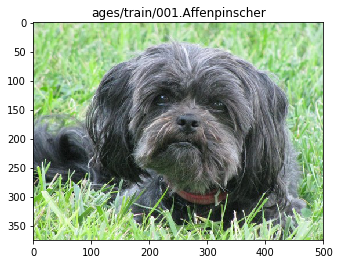

In [2]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline 

i=123
img = cv2.imread(test_files[i])
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb);
plt.title(dog_names[np.where(test_targets[i]==1)[0][0]]);

### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [3]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("../../../data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


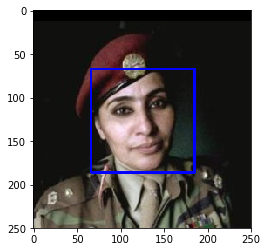

In [4]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

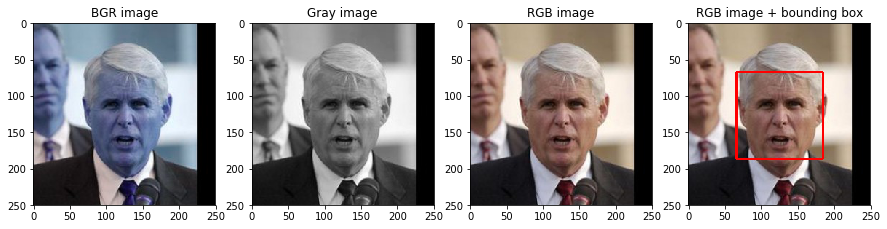

In [5]:
def display_face_detector(img_path):
    fig, ax = plt.subplots(1, 4, figsize=(15,5))

    # load color (BGR) image
    img = cv2.imread(img_path)
    # display color (BGR) image
    ax[0].imshow(img);
    ax[0].set_title('BGR image');

    # convert BGR image to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # display grayscale image
    ax[1].imshow(img_gray, cmap='gray', vmin=0, vmax=255);
    ax[1].set_title('Gray image');

    # find faces in image
    faces = face_cascade.detectMultiScale(gray)
    
    # convert BGR image to RGB for plotting
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # display color (RGB) image
    ax[2].imshow(img_rgb); 
    ax[2].set_title('RGB image');

    # get bounding box for each detected face
    for (x,y,w,h) in faces:
        # add bounding box to color image
        cv2.rectangle(img_rgb,(x,y),(x+w,y+h),(255,0,0),2)
    # display color (RGB) image and bounding box for each detected face
    ax[3].imshow(img_rgb); 
    ax[3].set_title('RGB image + bounding box');

img_path = human_files[0]
display_face_detector(img_path)

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [6]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

The following code cell, tests the performance of the `face_detector` function. We would like to know: 
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  The implemented algorithm falls short, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

In [22]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

## Testing the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
human_detected=[]
for human_img in human_files_short:
    human_detected.append(face_detector(human_img))
print('{}% of the first 100 images in human_files have a detected human face.'.format(sum(human_detected)))

human_detected=[]
for dog_img in dog_files_short:
    human_detected.append(face_detector(dog_img))
print('{}% of the first 100 images in dog_files have a detected human face!'.format(sum(human_detected)))

100% of the first 100 images in human_files have a detected human face.
11% of the first 100 images in dog_files have a detected human face!


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  First we download the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [9]:
from keras.applications.resnet50 import ResNet50

In [10]:
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 1s 0us/step


### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in the dataset!

In [11]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  For more Information, check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [12]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Dog Detector

In the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [13]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

The following code cell tests the performance of `dog_detector` function.  

In [21]:
### Testing the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

dog_detected=[]
for human_img in human_files_short:
    dog_detected.append(dog_detector(human_img))
print('{}% of the first 100 images in human_files have a detected dog!'.format(sum(dog_detected)))

dog_detected=[]
for dog_img in dog_files_short:
    dog_detected.append(dog_detector(dog_img))
print('{}% of the first 100 images in dog_files have a detected dog!'.format(sum(dog_detected)))

0% of the first 100 images in human_files have a detected dog!
100% of the first 100 images in dog_files have a detected dog!


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we create a CNN that classifies dog breeds.  We create the CNN _from scratch_ and test the model and its accuracy.  Later, in Step 5 of this notebook, we use transfer learning to create a CNN using transfer learning with improved accuracy.

We may need to limit the number of trainable layers!  More layer and parameters means longer training.

It is noteworthy assigning breed to dogs from images is considered exceptionally challenging. As an example, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  The vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

In addition, random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [15]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:08<00:00, 102.03it/s]


### (IMPLEMENTATION) Model Architecture

<br><b>2D convolution over an input</b>:
<li>filters to identify lower level features. padding='valid'. The input images are 224 by 224 with three channels. The output shape is 223 by 223 by 16.
<li>32 filters identifies more complex features. padding='valid'. The input shape is 111 by 111 by 16. The output shape is 110 by 110 by 32.
<li>64 filters identifies high level features. padding='valid'. The input shape is 55 by 55 by 32. The output shape is 27 by 27 by 64.

<br><b>MaxPooling layer after each converlutional layer</b>:
<li>Reduces the height and width by 50%.

<br><b>The GlobalAveragePooling layer</b>:
<li>Moving window over input data and pooling the data by averaging it, changes the size of height and width to one.

<br><b>Dense layer</b> (regular deeply connected neural network layer)
<li>activation function=relu 
<li>ctivation function=softmax : to output the 133 dog breed classes.

<br><b>Dropout</b>:
<li>Randomly sets input units to 0 with a frequency of 0.3 at each step during training time. It helps prevent overfitting and in this case, it improves test accuracy from 5% to 6%.

In [16]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

def build_cnn_model():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, padding='valid', activation='relu', input_shape=(224, 224, 3)))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=2, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=2, padding='valid', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(133, activation='softmax'))
    return model

model = build_cnn_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 223, 223, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 110, 110, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 54, 54, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 27, 27, 64)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
__________

### Compile the Model

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Training the model, and using model checkpointing to save the model that attains the best validation loss.

In [18]:
from keras.callbacks import ModelCheckpoint  

epochs = 20

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8830 - acc: 0.0091 - val_loss: 4.8688 - val_acc: 0.0108
Epoch 2/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8529 - acc: 0.0141 - val_loss: 4.8426 - val_acc: 0.0156
Epoch 3/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.8021 - acc: 0.0157 - val_loss: 4.7891 - val_acc: 0.0192
Epoch 4/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7667 - acc: 0.0175 - val_loss: 4.7577 - val_acc: 0.0192
Epoch 5/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.7273 - acc: 0.0192 - val_loss: 4.7611 - val_acc: 0.0240
Epoch 6/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.6924 - acc: 0.0237 - val_loss: 4.6958 - val_acc: 0.0240
Epoch 7/20
6680/6680 [==============================] - 21s 3ms/step - loss: 4.6520 - acc: 0.0240 - val_loss: 4.6710 - val_acc: 0.0251
Epoch 8/

### Load the Model with the Best Validation Loss

In [19]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Testing the model using the test dataset of dog images. 

In [20]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 6.1005%


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

In this section we use transfer learning to create a CNN that can identify dog breed from images.  The goal is to reach at least 60% accuracy on the test set.

We can use the bottleneck features from a different pre-trained model.
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  We use one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### (IMPLEMENTATION) Obtain Bottleneck Features

In [28]:
### Obtain bottleneck features from another pre-trained CNN.
from extract_bottleneck_features import *

bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture



<br><b>The GlobalAveragePooling layer</b>:
<li>Moving window over input data and pooling the data by averaging it, changes the size of height and width to one.

<br><b>Dense layer</b> (regular deeply connected neural network layer)
<li>activation function=relu 
<li>ctivation function=softmax : to output the 133 dog breed classes.

<br><b>Dropout</b>:
<li>Randomly sets input units to 0 with a frequency of 0.2 at each step during training time. It helps prevent overfitting and improves test accuracy.

In [29]:
### Define model architecture.

def build_Resnet50_model():
    model = Sequential()
    model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(133, activation='softmax'))    
    return model

Resnet50_model = build_Resnet50_model()
Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               524544    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               34181     
Total params: 558,725
Trainable params: 558,725
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [30]:
### Compile the model.

Resnet50_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Training the model and using model checkpointing to save the model that attains the best validation loss.   

In [31]:
### Train the model.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 330us/step - loss: 2.1513 - acc: 0.4811 - val_loss: 0.8982 - val_acc: 0.7090
Epoch 2/20
6680/6680 [==============================] - 2s 277us/step - loss: 0.7796 - acc: 0.7591 - val_loss: 0.7599 - val_acc: 0.7725
Epoch 3/20
6680/6680 [==============================] - 2s 277us/step - loss: 0.5274 - acc: 0.8322 - val_loss: 0.7386 - val_acc: 0.7701
Epoch 4/20
6680/6680 [==============================] - 2s 277us/step - loss: 0.3913 - acc: 0.8777 - val_loss: 0.7293 - val_acc: 0.7784
Epoch 5/20
6680/6680 [==============================] - 2s 274us/step - loss: 0.3110 - acc: 0.8961 - val_loss: 0.6883 - val_acc: 0.8084
Epoch 6/20
6680/6680 [==============================] - 2s 273us/step - loss: 0.2484 - acc: 0.9147 - val_loss: 0.7967 - val_acc: 0.7988
Epoch 7/20
6680/6680 [==============================] - 2s 274us/step - loss: 0.1981 - acc: 0.9325 - val_loss: 0.8636 - val_acc: 0.7856
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [32]:
### Load the model weights with the best validation loss.

Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Testing the model on the test dataset of dog images. It is desired to reach an accuracy greater than 60%.

In [33]:
### Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 81.2201%


### (IMPLEMENTATION) Predict Dog Breed with the Model

A function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted using the saved model.  

This function has the following three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Using the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to the chosen CNN architecture, we use the function

    extract_{network}
    
where `{network}`, in the above filename, is one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [34]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: The Algorithm

The algorithm accepts a file path to an image. First determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.


A sample image and output for the algorithm is provided below!

![Sample Human Output](images/sample_human_2.png)

This photo looks like an Afghan Hound.
### (IMPLEMENTATION) The Algorithm

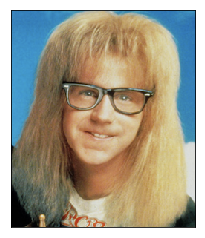

In [35]:
### The algorithm.

img_path = 'images/sample_human_2.png'
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb);
plt.xticks([]);plt.yticks([]);

In [36]:
img_tensor = path_to_tensor(img_path).astype('float32')/255

In [37]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [38]:
human = face_detector(img_path)
dog = dog_detector(img_path)

if not (human or dog):
    print('Neither human nor dog. ERROR!')
else:
    dog_breed_prediction = Resnet50_predict_breed(img_path)
    print(dog_breed_prediction)

if (human & dog):
    print('Algorithm is not sure if it is an image of a human or a dog!')
elif human:
    print('Human face.')
elif dog:
    print('Image of a dog.')

ages/train/002.Afghan_hound
Human face.


---
<a id='step6'></a>
## Step 6: Testing the Algorithm on Sample Images


<br><b>Discussion</b>:</br>
<li>The algorithm successfully classifies images of dgs and human with reasonable accuracy</li>
<li>The algorithm won't classifies cats as dogs or human</li>
<li>The algorithm fails in complex images (human wearing a mask) or low contrast images (e.g., a white dog in the snow)</li>
<br><b>How to improve the algorithm</b>:</br>
<li>Pre-process complex images</li>
<li>Implement more complex networks with more layers, implement dropout layer with different parameter</li>
<li>Implementing an improved face detection algorithm</li>
<li>Data augmentation to improve classifying images with different angles of dog faces</li>

In [43]:
## Execute the algorithm from Step 6 on sample images.

import re

def show_img_info(path):
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    human = face_detector(img_path)
    dog = dog_detector(img_path)

    if not (human or dog):
        fig_title = 'Neither human nor dog!!'
    else:
        breed_prediction = Resnet50_predict_breed(img_path)
        breed = breed_prediction[(re.search('\d+.', breed_prediction).span()[1]):]
        if (human & dog):
            fig_title = f'Not sure if it is a human or a dog! \n It resembles {breed}'
        elif human:
            fig_title = f'Human face. \n It looks like {breed}'
        elif dog:
            fig_title = f'Image of a dog. \n Breed: {breed}'
        
    fig = plt.figure()
    plt.imshow(img_rgb);
    plt.title(fig_title)
    plt.xticks([]);plt.yticks([]);

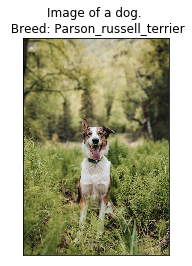

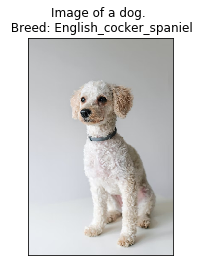

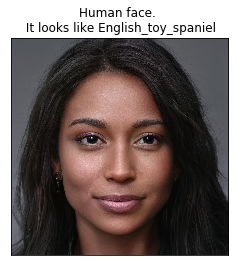

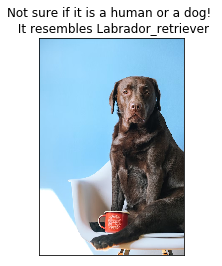

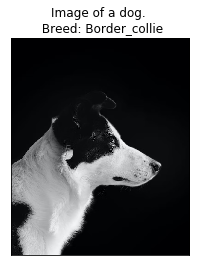

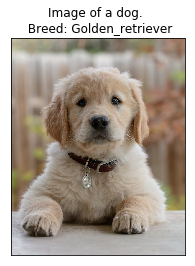

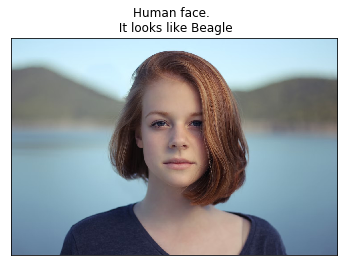

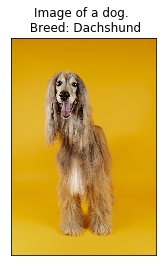

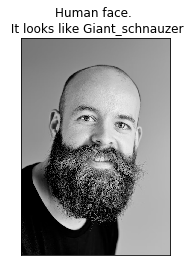

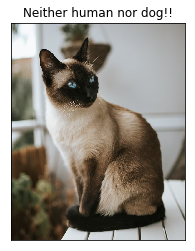

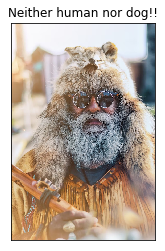

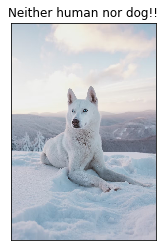

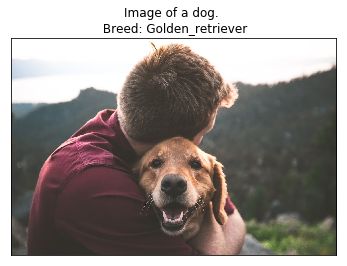

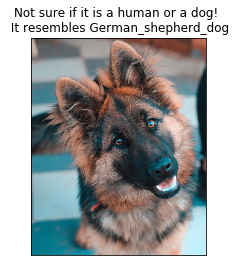

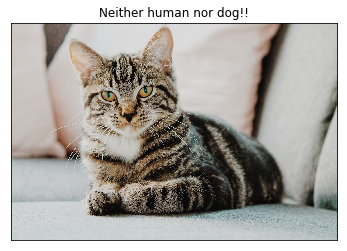

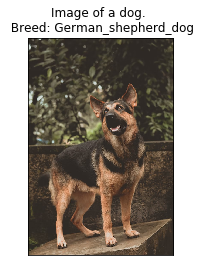

In [44]:
# assign directory
directory = 'test_images'
# iterate over image files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.jpg'):
        img_path = os.path.join(directory, filename)
        show_img_info(img_path)